In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from constraints import (
    epsilon,
    p,
    pQCD_likelihood,
    pQCD_constraints
)

from utils import (
    rcparams,
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre
    )

plt.rcParams.update(rcparams)

In [2]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values

CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

# Keys are different values for the renormalization scale parameter X
pQCD_values = {
    1: [2.6, 6.14, 2334/1000],
    2: [2.6, 6.47, 3823/1000],
    4: [2.6, 6.87, 4284/1000]
}

# Nuclear saturation density
nsat = 0.16

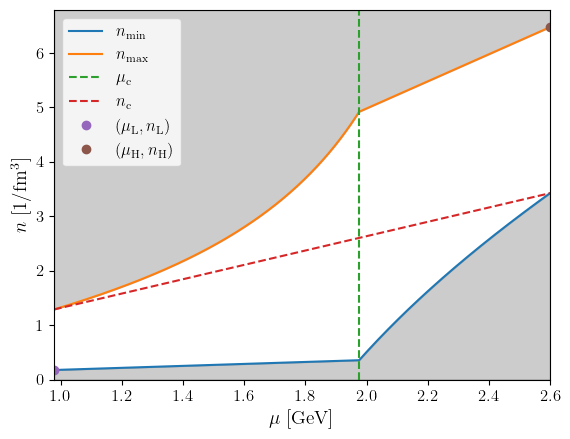

In [3]:
muL, nL, pL = CET_values['stiff']
muH, nH, pH = pQCD_values[2]

mu_array = np.linspace(muL, muH, 1000)

epsilonL = epsilon(muL, nL, pL)
epsilonH = epsilon(muH, nH, pH)

constraints = pQCD_constraints(muL, nL, pL, muH, nH, pH)
fig, ax = constraints.plot_mu_n(mu_array)

### Cubic

In [4]:
# Let's assume that the EOS has the form
def cubic_eos(mu, a, b, c, d):
    return a*mu**3 + b*mu**2 + c*mu + d

# The integral constraint (that is, that the area under the curve has to equal
# the change in pressure) means that given three of the four parameters then 
# the fourth is determined. For example, if we solve for d:
def d_func(a, b, c, muL, muH, pL, pH):
    DeltaP = pH - pL
    return (DeltaP - (a/4)*(muH**4 - muL**4) - (b/3)*(muH**3 - muL**3) - (c/2)*(muH**2 - muL**2))/(muH - muL)

# The causality constraint can be written in the following way:
def causality_test(a, b, d, mu):
    return np.all(2*a*mu**3 + 3*b*mu**2 >= d)

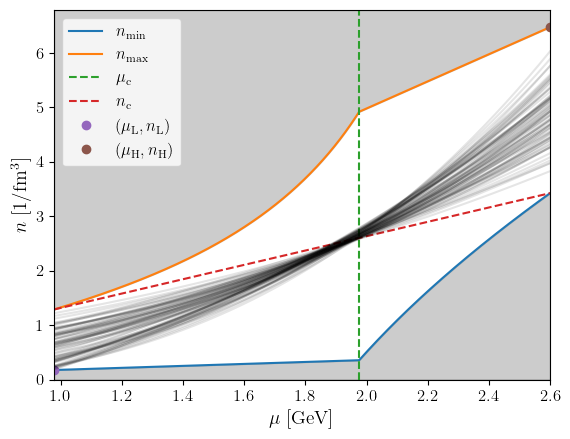

In [5]:
rng = np.random.default_rng()

# Let's generate some random values for the parameters
params = rng.uniform(0, 1, size=(1000, 3))

fig, ax = constraints.plot_mu_n(mu_array)

valid_eos_list = []
for a, b, c in params:
    d = d_func(a, b, c, muL, muH, pL, pH)
    eos = cubic_eos(mu_array, a, b, c, d)
    if (eos[0] > nL) & causality_test(a, b, d, mu_array):
        valid_eos_list.append(eos)
        ax.plot(mu_array, eos, alpha=0.1, c='k')

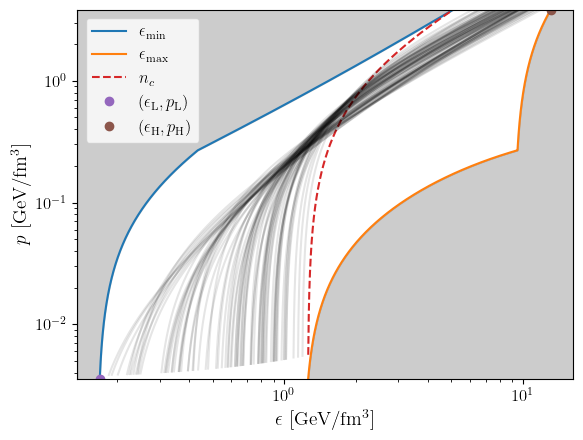

In [7]:
fig, ax = constraints.plot_epsilon_p(mu_array)

for eos in valid_eos_list:
    pressure = p(mu_array, eos, pL)
    ax.plot(
        epsilon(mu_array[1:], eos[1:], pressure), 
        pressure, alpha=0.1, c='k'
    )

### GP

In [9]:
def squared_exponential_kernel(t, tp, sigma=1, l=1):
    return sigma**2*np.exp(-(t-tp)**2/(2*l**2))

In [10]:
N = 200
mu_array = np.linspace(muL, muH, N)
Sigma = np.zeros((N, N))

for i, t in enumerate(mu_array):
    for j, tp in enumerate(mu_array):
        Sigma[i, j] = squared_exponential_kernel(t, tp, sigma=1, l=1)

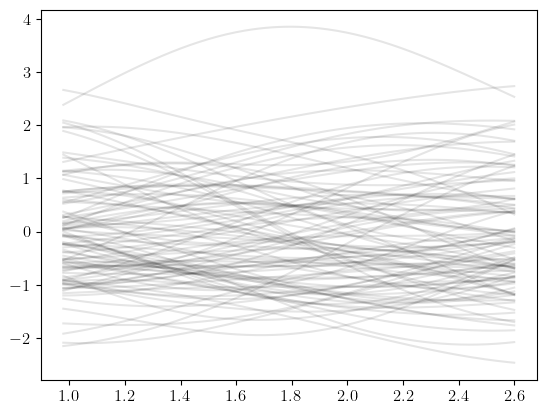

In [11]:
fig, ax = plt.subplots()

repeats = 100

for _ in range(repeats):
    ax.plot(mu_array, rng.multivariate_normal(np.zeros(N), Sigma), alpha=0.1, c='k')

In [12]:
training_x = np.array([muL, muH])
training_y = np.array([nL, nH])

training_dim = len(training_x)

xp = np.append(training_x, mu_array)

In [13]:
Sigma = np.zeros((N + training_dim, N + training_dim))

for i, t in enumerate(xp):
    for j, tp in enumerate(xp):
        Sigma[i, j] = squared_exponential_kernel(t, tp, sigma=5, l=1)

In [14]:
# Then we need to condition this thing, and in the process make it dimenion N
# again.

sigma_XX = Sigma[training_dim:, training_dim:]
sigma_YY = Sigma[:training_dim, :training_dim]

sigma_XY = Sigma[training_dim:, :training_dim]
sigma_YX = Sigma[:training_dim, training_dim:]

sigma_YY_inv = np.linalg.inv(sigma_YY)

mup = sigma_XY @ sigma_YY_inv @ training_y # mu_Y is zero?
Sigmap = sigma_XX - sigma_XY @ sigma_YY_inv @ sigma_YX

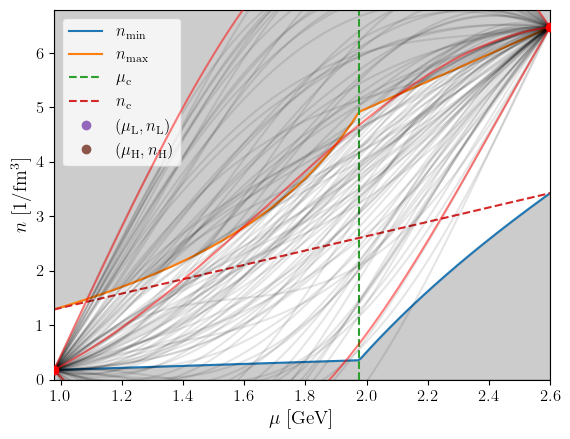

In [15]:
fig, ax = constraints.plot_mu_n(mu_array)

repeats = 100
for _ in range(repeats):
    eos = rng.multivariate_normal(mup, Sigmap)
    ax.plot(mu_array, rng.multivariate_normal(mup, Sigmap), alpha=0.1, c='k')

for x_train, y_train in zip(training_x, training_y):
    ax.scatter(x_train, y_train, c='r', zorder=10)

ax.plot(mu_array, mup, c='r', zorder=10, alpha=0.5)
ax.plot(mu_array, mup + 2*np.sqrt(np.diag(Sigmap)), c='r', zorder=10, alpha=0.5)
ax.plot(mu_array, mup - 2*np.sqrt(np.diag(Sigmap)), c='r', zorder=10, alpha=0.5)